## <모듈 import 및 전역 변수 설정>

In [1]:
import os
import sys 
sys.path.append('keras-retinanet')

import numpy as np
import pandas as pd
import cv2 
import matplotlib.pyplot as plt

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

import efficientnet.tfkeras as efn
# efn.preprocess_input(inputs)

In [2]:
THRES_SCORE = 0.5

# 클래스 파일 로드 
labels_to_names = pd.read_csv('../../data/vehicle-number-plate-detection/classes.csv',  header=None).T.loc[0].to_dict()

# 테스트 라벨 로드
test_df = pd.read_csv('../../data/vehicle-number-plate-detection/val-annotations.csv', names=['image_name', 'top_x', 'top_y', 'bottom_x', 'bottom_y', 'class_name'])
test_df.head(1)

,image_name,top_x,top_y,bottom_x,bottom_y,class_name
0,number_plates/licensed_car_115.jpeg,48,74,599,188,license_plate


In [3]:
# 모델 로드
model_path = './snapshots/EfficientNetB0_csv_26_1.863.h5'
model = models.load_model(model_path , backbone_name='EfficientNetB0')
model = models.convert_model(model)

## <함수 선언 및 테스트 데이터 결과 확인>

In [4]:
def infer(image):
    # 입력이미지에 대해 detector 모델이 inference한 내용을 리턴.
    image = efn.preprocess_input(image.copy())
    image, scale = resize_image(image)
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    boxes /= scale
    return boxes, scores, labels

In [5]:
def draw_detections(image, boxes, scores, labels):
    # detectino 결과 그리는 함수.
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < THRES_SCORE:
            break

        color = label_color(label)
        b = box.astype(int)
        draw_box(image, b, color=color)

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        draw_caption(image, b, caption)

In [6]:
def show_detected_objects(data_root_path, image_row):
    # 입력 이미지에 대해 inference후 결과를 보여주는 함수
    # 정답 박스는 노란색 / 예측 박스는 파란색
    img_path = image_row.image_name

    image = read_image_bgr(os.path.join(data_root_path, img_path))

    boxes, scores, labels = infer(image)
    boxes = boxes.numpy()
    scores = scores.numpy()
    labels = labels.numpy()

    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    true_box = [image_row.top_x, image_row.top_y, image_row.bottom_x, image_row.bottom_y]
    draw_box(draw, true_box, color=(255, 255, 0)) 
    draw_detections(draw, boxes, scores, labels)
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

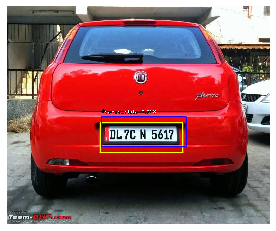

In [7]:
data_root_path = '../../data/vehicle-number-plate-detection'
show_detected_objects(data_root_path, test_df.iloc[1])